In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from ch4_metrics import evaluate_classifier

In [2]:
default_data = pd.read_csv('../data/default.csv')

In [3]:
display(default_data.head(3))

print('Shape:', default_data.shape)
print('Contains Missing Values:', default_data.isna().any().any())

print('\n{0}'.format(default_data['default'].value_counts()))
print('\n{0}'.format(default_data['student'].value_counts()))
print('\n{0}'.format(default_data.iloc[:, 2:].describe()))

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947


Shape: (10000, 4)
Contains Missing Values: False

No     9667
Yes     333
Name: default, dtype: int64

No     7056
Yes    2944
Name: student, dtype: int64

            balance        income
count  10000.000000  10000.000000
mean     835.374886  33516.981876
std      483.714985  13336.639563
min        0.000000    771.967729
25%      481.731105  21340.462903
50%      823.636973  34552.644802
75%     1166.308386  43807.729272
max     2654.322576  73554.233495


Value counts for 'default' indicate imbalanced classes. 

In [4]:
default_data['is_student'] = default_data['student'].map({'No': 0, 'Yes': 1})
default_data['defaulted'] = default_data['default'].map({'No': 0, 'Yes': 1})
default_data.head(3)

,default,student,balance,income,is_student,defaulted
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,1,0
2,No,No,1073.549164,31767.138947,0,0


In [5]:
# transform data from wide to long for balance income boxplots
balance_income_data = default_data[['defaulted', 'balance', 'income']].copy()
balance_income_data_long = balance_income_data.melt(
    id_vars=['defaulted'], 
    value_vars=['balance', 'income'], 
    var_name=['type']
)

In [6]:
# transform data for logistic regression
X = default_data[['balance', 'is_student']].to_numpy()
y = default_data['defaulted'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

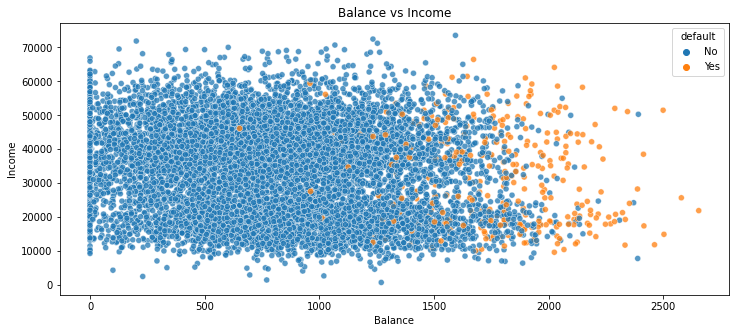

In [7]:
# visualize data
plt.figure(figsize=(12, 5))
default_scatterplot = sns.scatterplot(
    data=default_data,
    x='balance',
    y='income',
    hue='default',
    alpha=0.75
)
default_scatterplot.set(
    title='Balance vs Income', 
    xlabel='Balance', 
    ylabel='Income'
)
plt.show()

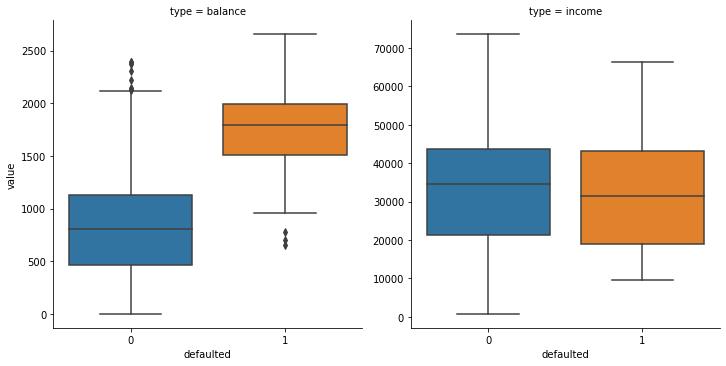

In [8]:
balance_income_boxplot = sns.catplot(
    data=balance_income_data_long, 
    x='defaulted', 
    y='value',
    col='type', 
    kind='box', 
    sharey=False
)
plt.show()

In [9]:
# train model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

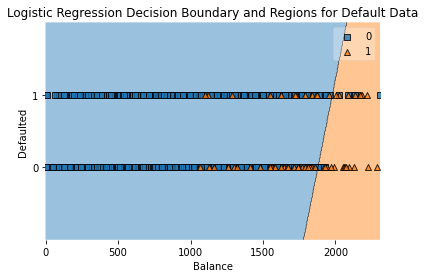

In [10]:
# visualize model results
ax = plot_decision_regions(X_test, y_test, classifier)
ax.set_title('Logistic Regression Decision Boundary and Regions for Default Data')
ax.set_xlabel('Balance')
ax.set_ylabel('Defaulted')
ax.set_yticks([0, 1])
plt.show()

In [11]:
def get_metrics(X, y, clf, threshold=0.5):
    # Get metrics for binary classifier
    y_probabilities = clf.predict_proba(X)
    y_pred = (y_probabilities[:, 1] > threshold).astype(int)
    
    unique_results = np.unique(y, return_counts=True)
    most_common_label = int(unique_results[0][unique_results[1].argmax()])
    y_null = np.zeros_like(most_common_label)

    accuracy = accuracy_score(y, y_pred)
    null_accuracy = accuracy_score(y, y_null)
    confusion = confusion_matrix(y, y_pred)
    f1 = f1_score(y, y_pred).round(3)
    precision = precision_score(y, y_pred).round(3)
    recall = recall_score(y, y_pred).round(3)

    return accuracy, null_accuracy, confusion, f1, precision, recall

In [12]:
# evaluate model
evaluate_classifier(X_test, y_test, classifier)

Accuracy: 0.9725
Null Accuracy:0.9665


Confusion Matrix:
[[1924    9]
 [  46   21]]

F1 Score: 0.433
Precision: 0.7
Recall: 0.313


Accuracy is not a good metric for assessing the logistic regression model due to class imbalance.
This is supported by how predicting the most common class results in an accuracy of 0.9665 in addition to the low recall. The low recall indicates a relatively high number of false negatives / Type II error.